# TAOS drifter deployments: tool development


- [ ] approximate time for deployment & currents (speed, direction)?
- [ ] GPS position onboard delphy: degrés décimaux, deg/min decimaux, deg/min/sec ?
- [ ] Outil de cartographie ? (rentrée positions)
- [ ] Téléphone boosté?
- [ ] Prise électrique à bord du Delphy: Oui

Land tool:

- [ ] automatic refresh: download and print in table
- [ ] high res bathymetry: pas sûr

Ship tool:

- [ ] manual input of coordinates
- [ ] update route with click


[Marc](https://marc.ifremer.fr/resultats/courants/modeles_mars2d_atlantique_nord_est/(variable)/courant/(typevisu)/map/(zoneid)/7418/(type)/canvas#appTop)


In [1]:
import os
from glob import glob

from datetime import datetime
from time import sleep

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import pyproj

import taos.utils as ut
import taos.insitu as ins
from taos.insitu import rad2deg, knot, lonc, latc

---

## useful metrics

In [2]:
ins.metrics_cheatsheet(lonc, latc)

 lon: 1 deg = 72.44km,  0.1 deg = 7.2km,  0.01 deg = 724.4m,  0.001 deg = 72.4m
 lon: 1 deg = 72.44km,  1 min = 1207.3m,  .1 min = 120.7m,  0.01 min = 12.1m
 lon: 1 deg = 72.44km,  1 sec = 20.1m,  .1 sec = 2.0m
-----------------------------------------------------------------
 lat: 1 deg = 111.23km,  0.1 deg = 11.1km,  0.01 deg = 1112.2m,  0.001 deg = 111.2m
 lat: 1 deg = 111.23km,  1 min = 1853.7m,  .1 min = 185.4m,  0.01 min = 18.5m
 lat: 1 deg = 111.23km,  1 sec = 30.9m,  .1 sec = 3.1m


🐷🐷🐷🐷🐨🌼🌼🌼💐💐🌾🌖🌾😋😋👩‍🦳👩‍🦳§😄😁😁😁😀😄😄(😃😄(😚😚😗)🙃😇😇😇😇🥳🥳😏🥳🥳😏🥳😏🥳)😡😡😡😡😡😡👹👹👹👺👺👺👾👽👾😿😿😿😸😹👍🖐🏻👉🏽👀👥👥👥👥👥👥👥🧑🏽‍🦰🧑🏽‍🦰👱‍♂️👱‍♂️👱‍♂️👱‍♂️😡🤕à🤕🤕🤒😷

---

## course resolution 

We want to find the time interval $\delta t$ and the heading $\theta$ such as we meet the trajectory of an ocean parcel initially located at a location $(\delta x, \delta y)$.
We also want to account for a waiting time $t_w$, i.e. we want to wait $t_w$ at the meeting location before the ocean parcel arrives.
This ship is assumed to be located at position $(0,0)$ initially.
We thus want to solve for  $\delta t$ and $\theta$ the following equation:

\begin{align}
\delta x + u_o (\delta t + t_w) = u_s \cos(\theta) \delta t, \\
\delta y + v_o (\delta t + t_w) = u_s \sin(\theta) \delta t,
\end{align}


In [3]:
Uo = .5 + 1j*0 # m/s
dX = 0 - 1j*1e3 # m
speed = 10*0.5 # m/s
time_waiting = 5*60 # seconds

theta, dt, _, X_launch, Us = ins.solve_route_heading(dX, speed, Uo, time_waiting)

print(f" New heading = {theta*rad2deg:.1f} at {speed/knot:.1f} knots ({speed:.1f}m/s), " \
      f"time to destination = {dt/60:.1f}min, waiting time: {time_waiting/60:.1f}min")

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 New heading = -75.8 at 9.7 knots (5.0m/s), time to destination = 3.4min, waiting time: 5.0min


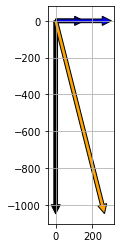

In [4]:
ins.plot_route_solution(dX, Us, Uo, dt, time_waiting)

- The orange arrow is the ship track.
- The black arrow is the target point initial position.
- The small blue arrow represents an ocean parcel displacement at the end of the transit time
- The larger blue arrow represents an ocean parcel displacement after transit plus waiting time

The question is solver when the sum of the larger blue arrow and the black arrow equal the orange one.

---

## deployment geometry


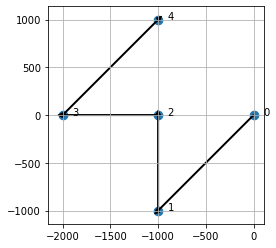

In [5]:
R, theta, N = 1e3, 0/rad2deg, 5
#X, dX = ins.build_polygon(L, theta, N, rotation=1)
X, dX = ins.build_square_with_center(R, theta, rotation=-1, center_loc=2)
ins.plot_polygon(X, dX)

Load Baie de Seine points of interests

In [6]:
ins.stations

,System,lon,lat
Epave nord Ouistreham,release,-0.246717,49.374433
LSTOuistreham,buoy,-0.246754,49.340379
Luc,buoy,-0.307225,49.345653


In [7]:
#lon_a, lat_a = -0.25, 49.33 # anchor point
anchor = ins.stations.loc["LSTOuistreham"]
lon_a, lat_a = anchor["lon"], anchor["lat"]

center_loc = 2
lon, lat, X = ins.build_square_geo(lon_a, lat_a, R, theta, rotation=-1, center_loc=center_loc)

### build a radiator for hydrological measurements

In [8]:
# find the square center
lonc, latc = lon[center_loc], lat[center_loc]
# build radiator
lon_radiator, lat_radiator, length_radiator, dX_radiator = ins.radiator(2.5*R, 3, theta, lonc, latc)

(0.7071067811865476+0.7071067811865476j)
Distance 7.63614234542708 NM


(-1944.543648263006, 1944.543648263006, -1944.543648263006, 1944.543648263006)

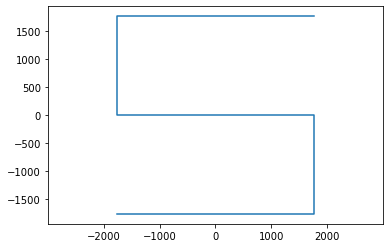

In [9]:
plt.plot(dX_radiator.real, dX_radiator.imag)
plt.axis("equal")

In [10]:
i=0
for _lon, _lat in zip(lon_radiator, lat_radiator):
    _lon_deg, _lon_min = ins.deg_mindec(_lon)
    _lat_deg, _lat_min = ins.deg_mindec(_lat)
    if _lon_deg<=0:
        EW="W"
    else:
        EW="E"
    print(f"Point {i}: {_lon_deg}{EW} {_lon_min:.3f}  {_lat_deg}N {_lat_min:.3f}")
    i+=1

Point 0: -0.0W 14.168  49.0N 21.376
Point 1: -0.0W 17.088  49.0N 21.379
Point 2: -0.0W 17.090  49.0N 20.425
Point 3: -0.0W 14.171  49.0N 20.422
Point 4: -0.0W 14.175  49.0N 19.468
Point 5: -0.0W 17.093  49.0N 19.472


### first drifter deployment coordinates

In [11]:
_lon_deg, _lon_min = ins.deg_mindec(lon_a)
_lat_deg, _lat_min = ins.deg_mindec(lat_a)

print(f"Anchor: {_lon_deg}{EW} {_lon_min:.3f}  {_lat_deg}N {_lat_min:.3f}")

Anchor: -0.0W 14.805  49.0N 20.423


### plot the overall deployment

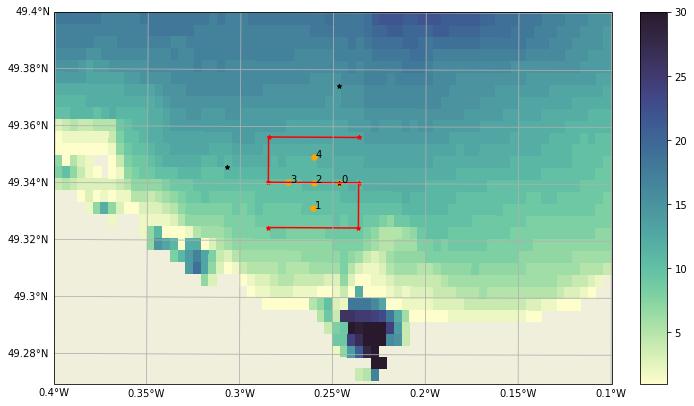

In [12]:
fac = ut.plot_bs(bathy=True, zoom=[-.4, -.1, 49.27, 49.4], vmax=30, figsize=(10,10))
ax = fac["ax"]

ax.scatter(lon, lat, 30, color="orange", transform=ut.ccrs.PlateCarree())

for i in range(lon.size):
    ax.text(lon[i]+1e-3, lat[i], f"{i}", transform=ut.ccrs.PlateCarree())

_s = ins.stations
ax.scatter(_s.lon, _s.lat, 20, color="black", marker="*", transform=ut.ccrs.PlateCarree())

ax.scatter(lon_radiator, lat_radiator, 20, color="red", marker="*", transform=ut.ccrs.PlateCarree())
ax.plot(lon_radiator, lat_radiator, color="red", transform=ut.ccrs.PlateCarree())

### solve route for drifter deployments

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


,time,lon,lat,heading,dt_route,dt_total,lon_deg,lon_min,lat_deg,lat_min
deployment,,,,,,,,,,
-1,2022-07-15 14:26:47.875635000,-0.246754,49.340379,NaN,NaN,NaN,-0.0,14.805240,49.0,20.422740
0,2022-07-15 14:31:48.875635000,-0.246819,49.340393,-3.455752,0.016667,5.016667,-0.0,14.809163,49.0,20.423579
1,2022-07-15 14:41:12.543873156,-0.258667,49.331417,-2.280540,4.394471,9.394471,-0.0,15.519991,49.0,19.884996
2,2022-07-15 14:49:34.110044899,-0.256915,49.340406,1.446056,3.359436,8.359436,-0.0,15.414919,49.0,20.424356
3,2022-07-15 14:57:30.300521210,-0.269038,49.340420,-3.141593,2.936508,7.936508,-0.0,16.142257,49.0,20.425220
4,2022-07-15 15:07:35.283591025,-0.253169,49.349393,0.715208,5.083051,10.083051,-0.0,15.190151,49.0,20.963563


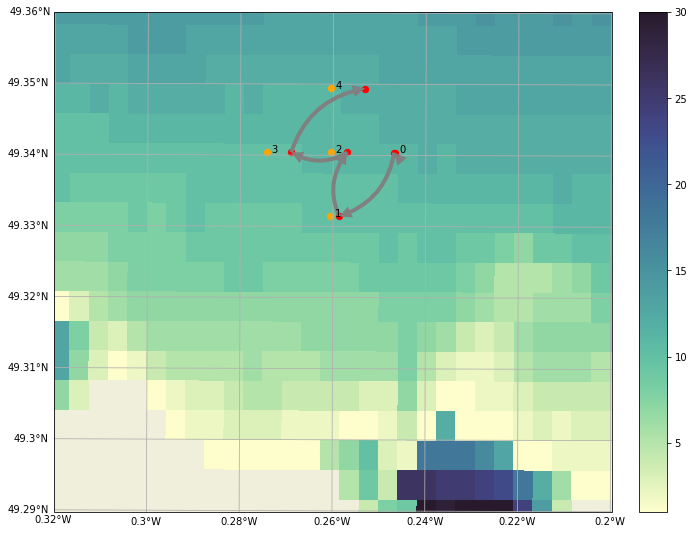

In [28]:
# anchor point
#L, theta = 2e3, 0/rad2deg
#lon_a, lat_a = -0.25, 49.33

Uo =  .25 + 1j*0 # m/s
speed = 10*0.5 # m/s
time_waiting = 5*60 # seconds

lon, lat, X = ins.build_square_geo(lon_a, lat_a, R, theta, rotation=-1, center_loc=2)

# deployment at ship location
df = ins.deployments_route_schedule(lon_a, lat_a, speed, lon, lat, time_waiting, Uo)
# deployment at predetermined anchor location
#df = ins.deployments_route_schedule(lon_a-0.02, lat_a, speed, lon, lat, time_waiting, Uo
#                    lon_a=lon_a, lat_a=lat_a,
#                   )
# underway deployment at location 2 and beyond
#df = ins.deployments_route_schedule(lon_a-0.02, lat_a, speed, lon, lat, time_waiting, Uo
#                    lon_a=lon_a, lat_a=lat_a, time_a=now()-pd.Timedelta("1min"),
#                    skip=2,
#                   )

ins.plot_deployments_route(lon, lat, df, bathy=True)

df



{'fig': <Figure size 720x720 with 2 Axes>,
 'ax': <GeoAxesSubplot:xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fc34011ebe0>}

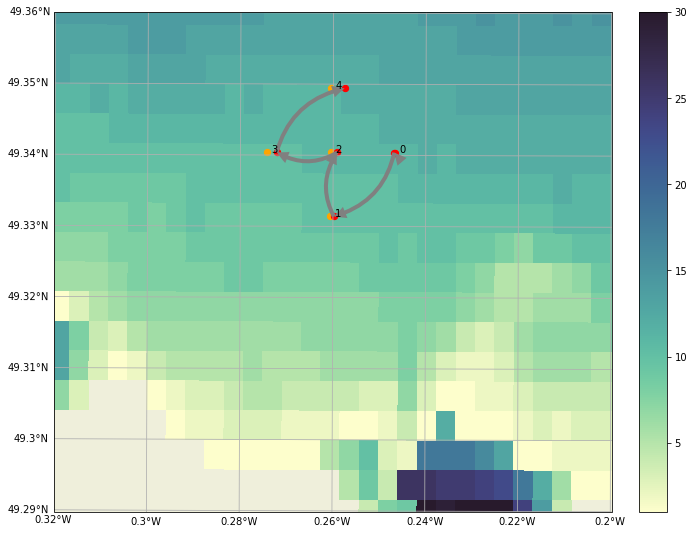

In [15]:
# debug
if False:
    #opts = dict(n=256, options=dict(disp=True))
    #opts = dict(n=512)
    _dX = dX[0]
    theta, dt_route, dt_total, X_launch, Us = ins.solve_route_heading(_dX, speed, Uo, time_waiting)
    ins.plot_route_solution(_dX, Us, Uo, dt_route, time_waiting)
    theta*rad2deg, dt_route/60, dt_total/60, X_launch, Us

In [16]:
ins.plot_deployments_route(dash.lon_vertices, dash.lat_vertices, dash.df, bathy=False, land=dict(scale="10m"), 
                           coast_resolution=None)

NameError: name 'dash' is not defined

---
## load drifter data

😹🧑🏽‍🦰🧑🏽‍🦰😸👺👺😍😍😌😍🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰😒😒😒😫😫😫😫😫😫😩😩😩😩😩😩😩😫😫😫😫😫😫😫😫😫😫😫🥵😬😬😬🙄🙄🙄🙄🙄😬😑😐🥶🥶🥶🥶🥶🥶🥶🥶😱😱😱😱🥵🥵🥶🥵🥵🥵🥵🥵🥵🥵🤮🥴🥴🤧🤧👶👶👶👶👥👥

🥶🥶🥶😚c😚😚😋🥅🥅🥅🥅🥊🥊🥊🥊🥊🥊🥊🥊🛷🛷🛷🛷🛷🛷🪂🪂🪂🪂🪂🪂🪂🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🎽🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋🥋⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷⛷m🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿🎿⛷⛷⛷⛷⛷⛷🛹🛹🛹🛹🛹🛹🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸🤸⛹️‍♂️⛹️‍♂️⛹🏻‍♀️⛹️‍♂️🤺🤺🤺


In [12]:
#ins.fetch_drifter_data()

In [13]:
dr = ins.load_drifter_data()
dr_now = ins.extrapolate(dr)

In [14]:
anchor = "0-4351896"
#...

---
### monitoring

In [15]:
%matplotlib inline

In [ ]:
ins.monitor_drifters(refresh_time=5/60)

---
## ship tools: manual logging

In [16]:
devices = list(dr)

In [17]:
#import ipywidgets as widgets
#import datetime

#from ipywidgets import GridspecLayout
#from ipywidgets import Button, Layout, jslink, IntText, IntSlider

#def create_expanded_button(description, button_style):
#    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))


In [18]:

d = ins.dashboard()
d.grid

#

GridspecLayout(children=(Dropdown(description='Device:', layout=Layout(grid_area='widget001'), options=(), val…

---

In [ ]:

class dashboard_speed(object):
    
    def __init__(self):
        #
        self.build_dashboard()
        self.update() # time

    def build_dashboard(self):
        
        w = dict()

        w["button"] = widgets.Button(
            description='Compute',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Click me',
            icon='check' # (FontAwesome names without the `fa-` prefix)
        )
        w["button"].on_click(self.compute)

        w["end_hour"] = widgets.Dropdown(
            options=np.arange(24),
            description='End - hour:',
            disabled=False,
        )

        w["end_minute"] = widgets.Dropdown(
            options=np.arange(60),
            description='End - minute:',
            disabled=False,
        )

        w["end_second"] = widgets.Dropdown(
            options=np.arange(60),
            description='End - second:',
            disabled=False,
        )

        w["end_lon_deg"] = widgets.Dropdown(
            options=["0W"], # to be generalized
            value="0W",
            description='End - lon [deg]:',
            disabled=False,
        )

        w["end_lon_min"] = widgets.Dropdown(
            options=np.arange(60),
            value=15,
            description='End - lon - [min]:',
            disabled=False,
        )

        w["end_lon_sec"] = widgets.FloatSlider(
            value=0.,
            min=0,
            max=60.0,
            step=0.1, # 0.1 sec = 2m
            description='End - lon [sec]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        #w["end_lat_deg"] = widgets.Dropdown(
        #    options=["49N"], # to be generalized
        #    value="49N",
        #    description='End - lat [deg]:',
        #    disabled=False,
        #)

        w["end_lat_min"] = widgets.Dropdown(
            options=np.arange(60),
            value=19,
            description='End - lat [min]:',
            disabled=False,
        )

        w["end_lat_sec"] = widgets.FloatSlider(
            value=0.,
            min=0,
            max=60.0,
            step=0.1, # 0.1 sec = 2m
            description='End - lat [sec]:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
        )

        #
        grid = widgets.GridspecLayout(4, 3, height='200px', align_items="center")

        #grid[0, 0] = w["device"]
        grid[0, 1] = w["button"]

        #
        #grid[0, 2] = w["date"]
        grid[1, 2] = w["hour"]
        grid[2, 2] = w["minute"]
        #grid[3, 2] = w["second"]

        #
        #grid[1, 0] = w["lon_deg"]
        grid[2, 0] = w["lon_min"]
        #grid[3, 0] = w["lon_sec"]

        #
        #grid[1, 1] = w["lat_deg"]
        grid[2, 1] = w["lat_min"]
        #grid[3, 1] = w["lat_sec"]

        # store
        self.grid = grid
        self.w = w
        
    def update(self):
        _now = datetime.utcnow()
        self.w["date"].value = _now
        self.w["hour"].value = _now.hour
        self.w["minute"].value = _now.minute
        self.w["second"].value = _now.second
                
    def register(self, button):
        w = self.w
        #
        date = w["date"].value
        time = pd.Timestamp(year=date.year, month=date.month, day=date.day,
                            hour=w["hour"].value, minute=w["minute"].value, second=w["second"].value,
                           )
        #
        lond = w["lon_deg"].value
        lon = float(lond[:-1])
        if lond[-1]=="W":
            sign = -1
        else:
            sign = 1
        lon = sign * (lon + w["lon_min"].value/60 + w["lon_sec"].value/3600)
        #
        latd = w["lat_deg"].value
        lat = float(latd[:-1])
        if latd[-1]=="N":
            sign = 1
        else:
            sign = -1
        lat = sign * (lat + w["lat_min"].value/60 + w["lat_sec"].value/3600)
        #
        s = pd.Series(dict(device=w["device"].value,
                           time=time,
                           lon=lon,
                           lat=lat,
                          )
                     )
        # store
        (s.to_frame().T
         .rename_axis('event')
         .to_csv(self.log, mode='a', header=not os.path.exists(self.log))
        )
        
    def load_log(self):
        """load log file"""
        df = pd.read_csv(d.log, parse_dates=["time"])
        return df